## Network Anomaly Detection System with Hybrid ML + Rule-Based Detection
#### Requirements: pip install numpy pandas scikit-learn flask flask-socketio

--- 
### Part 1: Static Model Training & Threshold Analysis
First, we will load the historical data, train all our anomaly detection models, and determine the thresholds for 7 different detection methods. These trained models (`scaler`, `iso`, `lof`, `ocsvm`, etc.) will be used by the live app in Part 2.

In [43]:
# Imports
import numpy as np
import pandas as pd
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.decomposition import PCA
from datetime import datetime
import time
import random
from flask import Flask, render_template_string
from flask_socketio import SocketIO, emit
import json
import seaborn as sns
import matplotlib.pyplot as plt
import threading

In [44]:
# Load training data and suspicious ports list
ns_data = pd.read_csv('embedded_system_network_security_dataset.csv')
sus_ports_df = pd.read_csv('suspicious_ports_list.csv')

In [45]:
ns_data.head()

,packet_size,inter_arrival_time,src_port,dst_port,packet_count_5s,mean_packet_size,spectral_entropy,frequency_band_energy,label,protocol_type_TCP,protocol_type_UDP,src_ip_192.168.1.2,src_ip_192.168.1.3,dst_ip_192.168.1.5,dst_ip_192.168.1.6,tcp_flags_FIN,tcp_flags_SYN,tcp_flags_SYN-ACK
0,0.405154,0.620362,62569,443,0.857143,0.0,0.834066,0.534891,0.0,False,True,True,False,False,False,False,False,False
1,0.527559,0.741288,59382,443,0.785714,0.0,0.147196,0.990757,0.0,False,True,False,False,False,True,False,True,False
2,0.226199,0.485116,65484,80,0.285714,0.0,0.855192,0.031781,0.0,False,True,False,False,True,False,False,False,False
3,0.573372,0.450965,51707,53,0.142857,0.0,0.153220,0.169958,0.0,False,False,False,True,False,False,False,False,False
4,0.651396,0.888740,26915,53,0.714286,0.0,0.923916,0.552053,0.0,True,False,False,True,False,False,False,True,False


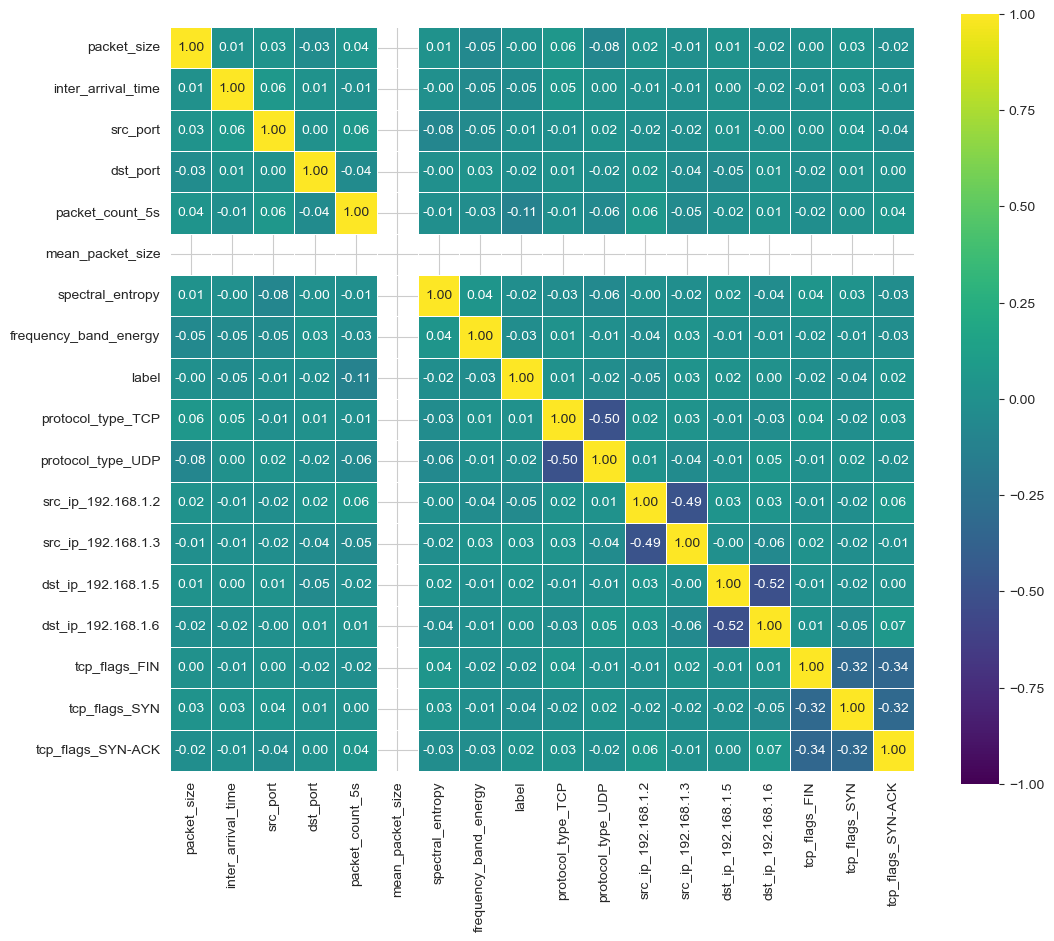

In [46]:
# Create an annotated heatmap
plt.figure(figsize = (12,10))
plt.rcParams.update({'font.size': 10})
sns.heatmap(ns_data.corr(), cmap = 'viridis', vmin = -1, vmax = 1, center = 0, annot=True, fmt=".2f", square=True, linewidths=.5, )
plt.show()

In [47]:
# Prepare data for modeling
# We will use all columns except 'label' as features for our unsupervised models.
feature_names = [col for col in ns_data.columns if col != 'label']
X = ns_data[feature_names].values

# Scale all features
# This scaler will be saved and used by the live app.
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

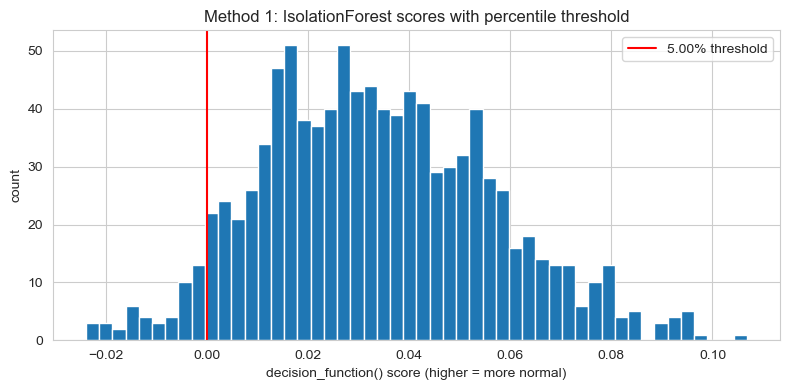

Percentile threshold = -0.0000, anomalies = 50


In [48]:
# Method 1: IsolationForest with 5% Percentile Threshold
contamination = 0.05

iso = IsolationForest(n_estimators=200, contamination=contamination, random_state=42)
iso.fit(X_scaled)
scores_iso = iso.decision_function(X_scaled)

threshold_iso_pct = np.percentile(scores_iso, 100 * contamination)
pred_iso_pct = np.where(scores_iso < threshold_iso_pct, -1, 1)

# Plot
plt.figure(figsize=(8,4))
plt.hist(scores_iso, bins=50)
plt.axvline(threshold_iso_pct, color='r', linestyle='-', label=f'{100*contamination:.2f}% threshold')
plt.title("Method 1: IsolationForest scores with percentile threshold")
plt.xlabel("decision_function() score (higher = more normal)")
plt.ylabel("count")
plt.legend()
plt.tight_layout()
plt.show()
print(f"Percentile threshold = {threshold_iso_pct:.4f}, anomalies = {np.sum(pred_iso_pct==-1)}")

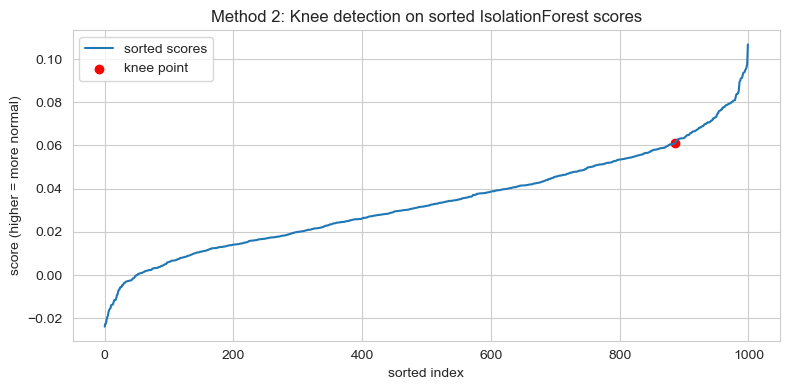

Knee threshold = 0.0610, anomalies = 886


In [49]:
# Method 2: IsolationForest with Knee Detection Threshold
s = np.sort(scores_iso)         # ascending => most anomalous first
n = len(s)
x = np.arange(n)
line_start, line_end = np.array([0, s[0]]), np.array([n-1, s[-1]])
num = abs((s[-1]-s[0])*x - (n-1)*(s - s[0]))
den = np.sqrt((s[-1]-s[0])**2 + (n-1)**2)
dist = num / den
knee_idx = np.argmax(dist)
threshold_iso_knee = s[knee_idx]
pred_iso_knee = np.where(scores_iso < threshold_iso_knee, -1, 1)

# Plot
plt.figure(figsize=(8,4))
plt.plot(x, s, label="sorted scores")
plt.scatter(knee_idx, s[knee_idx], color='r', label="knee point")
plt.title("Method 2: Knee detection on sorted IsolationForest scores")
plt.xlabel("sorted index")
plt.ylabel("score (higher = more normal)")
plt.legend()
plt.tight_layout()
plt.show()

print(f"Knee threshold = {threshold_iso_knee:.4f}, anomalies = {np.sum(pred_iso_knee==-1)}")

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


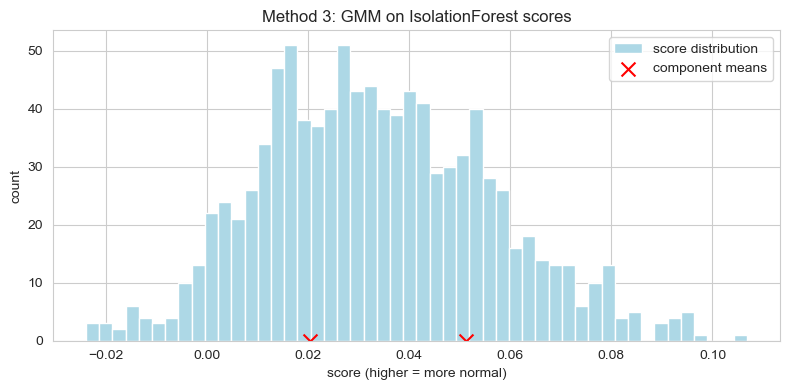

GMM anomaly component mean = 0.0203, anomalies = 599


In [50]:
# Method 3: IsolationForest with GMM Threshold
s_col = scores_iso.reshape(-1,1)
gmm = GaussianMixture(n_components=2, random_state=0).fit(s_col)
labels = gmm.predict(s_col)        # 0 or 1 component assignment
means = gmm.means_.ravel()
anomaly_comp = np.argmin(means)    # component with lower (more anomalous) mean
pred_gmm = np.where(labels == anomaly_comp, -1, 1)

# Plot
plt.figure(figsize=(8,4))
plt.hist(scores_iso, bins=50, color='lightblue', label='score distribution')
plt.scatter(means, [0,0], color='red', marker='x', s=100, label='component means')
plt.title("Method 3: GMM on IsolationForest scores")
plt.xlabel("score (higher = more normal)")
plt.ylabel("count")
plt.legend()
plt.tight_layout()
plt.show()

print(f"GMM anomaly component mean = {means[anomaly_comp]:.4f}, anomalies = {np.sum(pred_gmm==-1)}")

LOF (5% Pct) anomalies = 50
OC-SVM (5% Pct) anomalies = 50


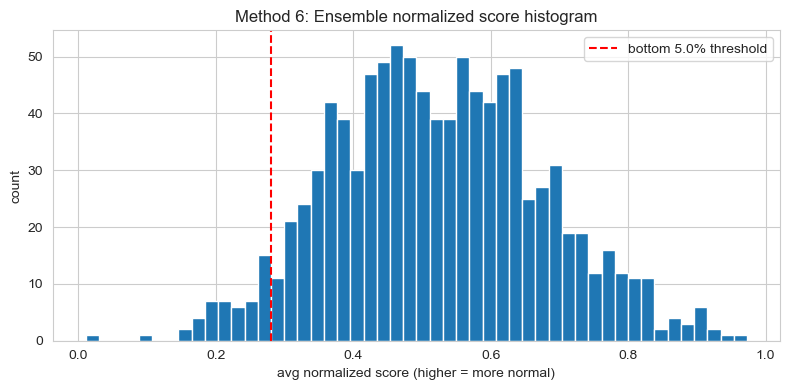

Ensemble threshold = 0.2811, anomalies = 50


In [51]:
# Methods 4, 5, 6: LOF, OneClassSVM, and Ensemble Average

contamination_pct = 0.05

# Fit LOF and OneClassSVM
lof = LocalOutlierFactor(n_neighbors=20, novelty=True, contamination=contamination_pct).fit(X_scaled)
ocsvm = OneClassSVM(nu=contamination_pct, gamma='scale').fit(X_scaled)

scores_lof = lof.decision_function(X_scaled)
scores_ocsvm = ocsvm.decision_function(X_scaled)

# Method 4: LOF (5% Percentile)
threshold_lof_pct = np.percentile(scores_lof, 100 * contamination_pct)
pred_lof_pct = np.where(scores_lof < threshold_lof_pct, -1, 1)
print(f"LOF (5% Pct) anomalies = {np.sum(pred_lof_pct==-1)}")

# Method 5: OC-SVM (5% Percentile)
threshold_ocsvm_pct = np.percentile(scores_ocsvm, 100 * contamination_pct)
pred_ocsvm_pct = np.where(scores_ocsvm < threshold_ocsvm_pct, -1, 1)
print(f"OC-SVM (5% Pct) anomalies = {np.sum(pred_ocsvm_pct==-1)}")

# Method 6: Ensemble Average Score (5% Percentile)
mms = MinMaxScaler()
norm_scores = mms.fit_transform(np.vstack([scores_iso, scores_lof, scores_ocsvm]).T)
avg_score = np.mean(norm_scores, axis=1)

threshold_ens_pct = np.percentile(avg_score, 100 * contamination_pct)
pred_ens_pct = np.where(avg_score < threshold_ens_pct, -1, 1)

# Plot
plt.figure(figsize=(8,4))
plt.hist(avg_score, bins=50)
plt.axvline(threshold_ens_pct, color='r', linestyle='--', label=f'bottom {100*contamination_pct:.1f}% threshold')
plt.title("Method 6: Ensemble normalized score histogram")
plt.xlabel("avg normalized score (higher = more normal)")
plt.ylabel("count")
plt.legend()
plt.tight_layout()
plt.show()

print(f"Ensemble threshold = {threshold_ens_pct:.4f}, anomalies = {np.sum(pred_ens_pct==-1)}")

In [52]:
# Method 7: Voting Classifier (This logic is for analysis only, final logic is in the live app)
# Convert predictions (1=normal, -1=anomaly) to votes (0=normal, 1=anomaly)
vote_iso_pct = (pred_iso_pct == -1).astype(int)
vote_iso_knee = (pred_iso_knee == -1).astype(int)
vote_gmm = (pred_gmm == -1).astype(int)
vote_lof = (pred_lof_pct == -1).astype(int)
vote_ocsvm = (pred_ocsvm_pct == -1).astype(int)
vote_ensemble = (pred_ens_pct == -1).astype(int)

# Sum the votes (6 models in total)
total_votes = vote_iso_pct + vote_iso_knee + vote_gmm + vote_lof + vote_ocsvm + vote_ensemble

# Set threshold: 3 or more models vote for anomaly (used for visualization)
VOTE_THRESHOLD = 4
pred_voting = np.where(total_votes >= VOTE_THRESHOLD, -1, 1)

print(f"Voting anomalies (>= {VOTE_THRESHOLD} votes): {np.sum(pred_voting == -1)}")

Voting anomalies (>= 4 votes): 54


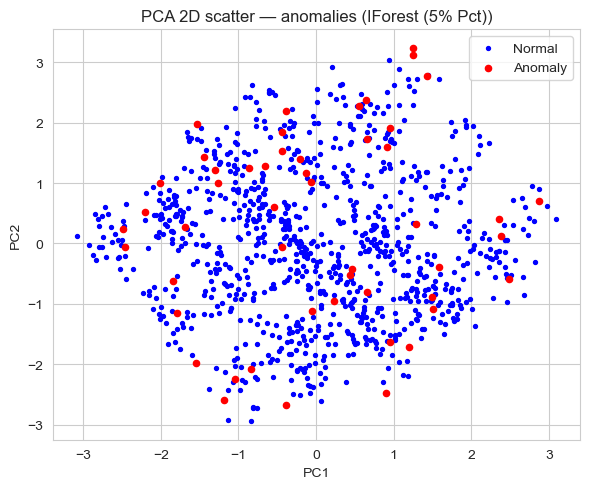

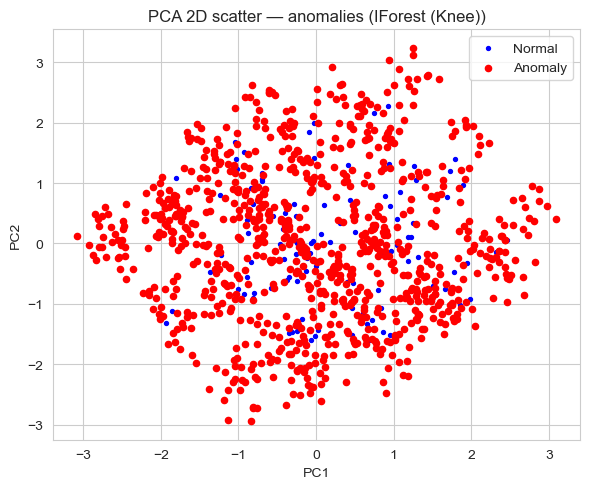

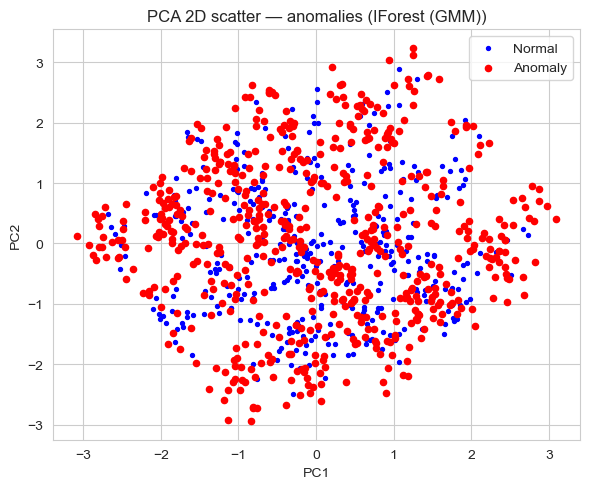

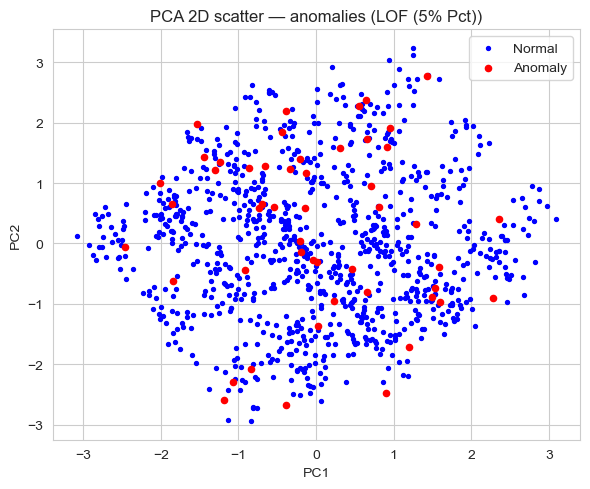

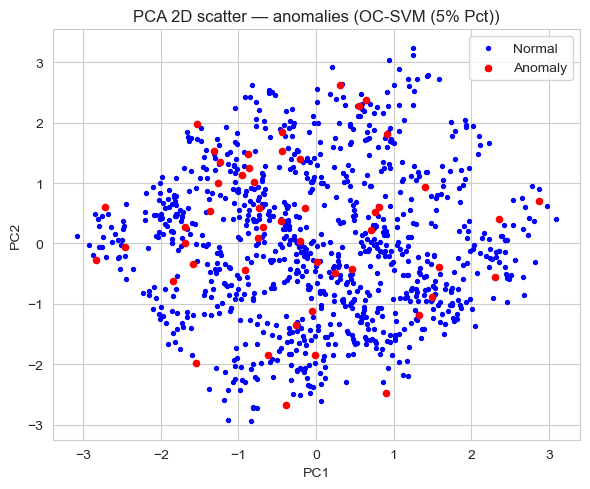

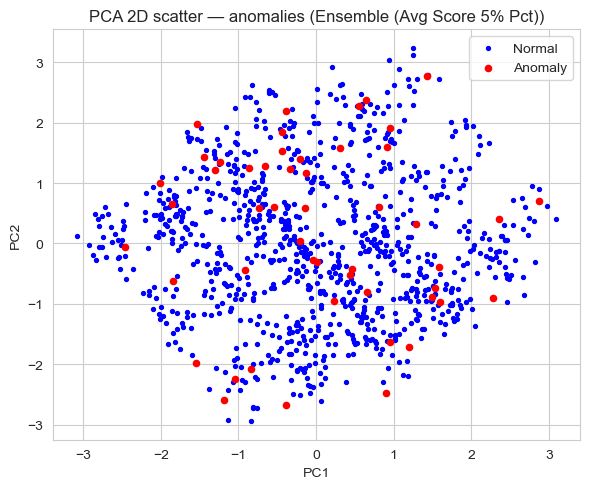

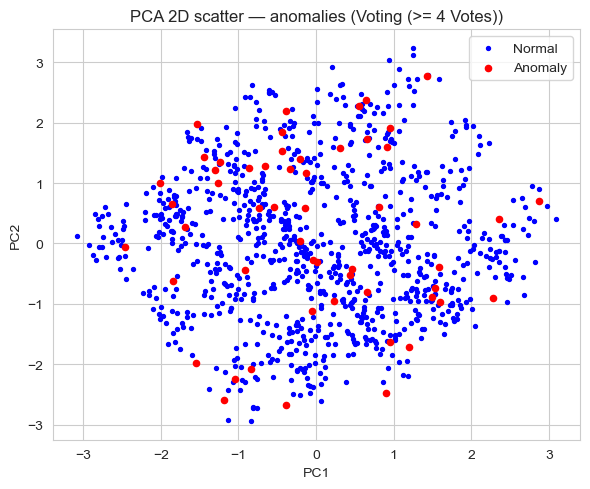

In [53]:
# Visualize all predictions on 2D PCA projection

pca = PCA(n_components=2, random_state=0)
X_pca = pca.fit_transform(X_scaled)

method_names = [
    "IForest (5% Pct)", 
    "IForest (Knee)", 
    "IForest (GMM)", 
    "LOF (5% Pct)", 
    "OC-SVM (5% Pct)", 
    "Ensemble (Avg Score 5% Pct)", 
    f"Voting (>= {VOTE_THRESHOLD} Votes)"
]

all_preds = [
    pred_iso_pct, 
    pred_iso_knee, 
    pred_gmm, 
    pred_lof_pct, 
    pred_ocsvm_pct, 
    pred_ens_pct, 
    pred_voting
]

for method_name, preds in zip(method_names, all_preds):
    plt.figure(figsize=(6, 5))
    plt.scatter(X_pca[:,0], X_pca[:,1], s=8, c='blue', label='Normal')
    anom_idx = np.where(preds == -1)[0]
    plt.scatter(X_pca[anom_idx,0], X_pca[anom_idx,1], c='red', s=20, label='Anomaly')
    plt.title(f"PCA 2D scatter — anomalies ({method_name})")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.legend()
    plt.tight_layout()
    plt.show()

In [54]:
# Create a final DataFrame with original data and all predictions/scores
predictions_df = pd.DataFrame({
    "IF_Pct_Pred": pred_iso_pct,
    "IF_Knee_Pred": pred_iso_knee,
    "GMM_Pred": pred_gmm,
    "LOF_Pred": pred_lof_pct,
    "OCSVM_Pred": pred_ocsvm_pct,
    "Ensemble_Pred": pred_ens_pct,
    "Voting_Pred": pred_voting,
    "Total_Votes": total_votes,
    "Score_IForest": scores_iso,
    "Score_LOF": scores_lof,
    "Score_OCSVM": scores_ocsvm,
    "Score_Ensemble_Avg": avg_score
})

# Concatenate with original data (reset index to ensure alignment)
data_with_predictions = pd.concat([ns_data.reset_index(drop=True), predictions_df.reset_index(drop=True)], axis=1)

print(f"Total anomalies found by Voting (>= {VOTE_THRESHOLD} votes): {np.sum(pred_voting == -1)}")
data_with_predictions.head()

Total anomalies found by Voting (>= 4 votes): 54


,packet_size,inter_arrival_time,src_port,dst_port,packet_count_5s,mean_packet_size,spectral_entropy,frequency_band_energy,label,protocol_type_TCP,...,GMM_Pred,LOF_Pred,OCSVM_Pred,Ensemble_Pred,Voting_Pred,Total_Votes,Score_IForest,Score_LOF,Score_OCSVM,Score_Ensemble_Avg
0,0.405154,0.620362,62569,443,0.857143,0.0,0.834066,0.534891,0.0,False,...,1,1,1,1,1,1,0.042464,0.025032,1.063653,0.539465
1,0.527559,0.741288,59382,443,0.785714,0.0,0.147196,0.990757,0.0,False,...,-1,1,1,1,1,2,0.014662,0.018743,0.102040,0.360618
2,0.226199,0.485116,65484,80,0.285714,0.0,0.855192,0.031781,0.0,False,...,1,1,1,1,1,1,0.046921,0.031215,0.604804,0.519901
3,0.573372,0.450965,51707,53,0.142857,0.0,0.153220,0.169958,0.0,False,...,1,1,1,1,1,0,0.074281,0.063916,1.846153,0.784124
4,0.651396,0.888740,26915,53,0.714286,0.0,0.923916,0.552053,0.0,True,...,-1,1,1,1,1,2,0.037790,0.045024,1.068614,0.572840


In [55]:
# Clean up the suspicious ports dataframe and define the set for rule-based engine
sus_ports_df.drop(columns=['metadata_link', 'metadata_reference'], inplace=True, errors='ignore')
sus_ports_df = pd.DataFrame(sorted(sus_ports_df.values, key=lambda x: x[2]))
sus_ports_df.columns = ['port', 'description', 'severity', 'type', 'source']
SUSPICIOUS_PORTS = set(sus_ports_df['port'].astype(int))
sus_ports_sample = random.sample(list(SUSPICIOUS_PORTS), 20) # Sample a few for the generator
sus_ports_df.head()

,port,description,severity,type,source
0,1015,Doly trojan,high,malware,hunting
1,1042,Bla trojan,high,malware,hunting
2,1075,Backdoor.Win32.LanaFTP.k listening on this port,high,malware,hunting
3,1170,Psyber Stream Server - PSS,high,malware,hunting
4,1243,SubSeven backdoor,high,malware,hunting


--- 
## Real-Time Hybrid Anomaly Detection Flask App (Using Pre-Trained Models + Rule-Based Engine)

This Flask application now implements the final **hybrid voting logic**:
1.  **6 ML Votes**: Anomaly if Rule-Based Confidence $\ge 60\%$.
2.  **5 ML Votes**: Anomaly if Rule-Based Confidence $\ge 80\%$.
3.  **4 ML Votes**: Anomaly if Rule-Based Confidence $\ge 90\%$.
4.  **$0-3$ ML Votes**: Always Normal.

In [56]:
# Initialize Flask app
app = Flask(__name__)
app.config['SECRET_KEY'] = 'secret-key'
socketio = SocketIO(app, cors_allowed_origins="*")

# Global variables for Flask App
MAX_HISTORY = 200
traffic_history = []
anomaly_history = []
stats = {
    'total_packets': 0,
    'normal_traffic': 0,
    'anomalies_detected': 0,
    'rule_based_detections': 0,
    'hybrid_detections': 0,
    'threat_level': 'Low'
}

# Configuration for App
ATTACK_TYPES = ['DDoS', 'Port Scan', 'Brute Force', 'Data Exfiltration', 'Malware C&C']

# Get the feature names from the original dataframe (excluding 'label')
PACKET_FEATURE_NAMES = [col for col in ns_data.columns if col != 'label']
print(f"Models were trained on these {len(PACKET_FEATURE_NAMES)} features: {PACKET_FEATURE_NAMES}")

Models were trained on these 17 features: ['packet_size', 'inter_arrival_time', 'src_port', 'dst_port', 'packet_count_5s', 'mean_packet_size', 'spectral_entropy', 'frequency_band_energy', 'protocol_type_TCP', 'protocol_type_UDP', 'src_ip_192.168.1.2', 'src_ip_192.168.1.3', 'dst_ip_192.168.1.5', 'dst_ip_192.168.1.6', 'tcp_flags_FIN', 'tcp_flags_SYN', 'tcp_flags_SYN-ACK']


In [57]:
def generate_network_packet():
    """Generate simulated network traffic matching the 17-feature CSV structure"""
    global sus_ports_sample, PACKET_FEATURE_NAMES
    
    # 1. Simulate the 8 numeric features (scaled 0-1 like the train csv data)
    # Note: These values are generated randomly, the ML models will determine if the combination is anomalous or not
    packet = {
        'packet_size': random.uniform(0, 1),
        'inter_arrival_time': random.uniform(0, 1),
        'packet_count_5s': random.uniform(0, 1),
        'mean_packet_size': 0.0,
        'spectral_entropy': random.uniform(0, 1),
        'frequency_band_energy': random.uniform(0, 1),
        'src_port': random.randint(1024, 65535),
        # ~15% chance of suspicious port
        'dst_port': random.choice([80, 443, 53] * 50 + sus_ports_sample * 10)
    }
    
    # Simulate the 9 boolean/categorical features
    tcp_syn = random.choice([True, False])
    tcp_fin = random.choice([True, False])
    tcp_syn_ack = random.choice([True, False]) if not tcp_syn and not tcp_fin else False
    
    # Protocol types
    packet['protocol_type_TCP'] = random.choice([True, False])
    packet['protocol_type_UDP'] = random.choice([True, False]) if not packet['protocol_type_TCP'] else False
    
    # IP addresses (just a simulation)
    src_2 = random.choice([True, False])
    src_3 = random.choice([True, False]) if not src_2 else False
    packet['src_ip_192.168.1.2'] = src_2
    packet['src_ip_192.168.1.3'] = src_3
    
    dst_5 = random.choice([True, False])
    dst_6 = random.choice([True, False]) if not dst_5 else False
    packet['dst_ip_192.168.1.5'] = dst_5
    packet['dst_ip_192.168.1.6'] = dst_6
    
    # TCP Flags
    packet['tcp_flags_FIN'] = tcp_fin
    packet['tcp_flags_SYN'] = tcp_syn
    packet['tcp_flags_SYN-ACK'] = tcp_syn_ack
    
    # Add non-feature metadata for the dashboard
    packet['id'] = time.time() + random.random()
    packet['timestamp'] = datetime.now().strftime('%H:%M:%S')
    packet['src_ip_str'] = '192.168.1.2' if src_2 else ('192.168.1.3' if src_3 else '192.168.1.1')
    packet['dst_ip_str'] = '192.168.1.5' if dst_5 else ('192.168.1.6' if dst_6 else '10.0.0.10')

    return packet

In [58]:
def rule_based_security_engine(packet):
    """Checks packet against security rules and returns a confidence score (0-100)"""
    global SUSPICIOUS_PORTS
    
    confidence = 0
    
    # Rule 1: Suspicious Port Access (High Confidence)
    if packet['dst_port'] in SUSPICIOUS_PORTS:
        confidence += 50
    
    # Rule 2: Suspicious Flag combination (e.g., FIN/SYN set in the same TCP segment)
    if packet['tcp_flags_SYN'] and not packet['tcp_flags_SYN-ACK'] and packet['protocol_type_TCP']:
        confidence += 30
    
    # Rule 3: Combined high-entropy/size values (simulated rule based on CSV features)
    if packet['spectral_entropy'] > 0.9 and packet['packet_size'] > 0.9:
        confidence += 10

    return min(confidence, 100)

In [59]:
def process_packet(packet):
    """Process a packet using the Hybrid ML Voting and Rule-Based logic"""
    global stats, traffic_history, anomaly_history, scaler, iso, lof, ocsvm, gmm, mms
    global threshold_iso_pct, threshold_iso_knee, threshold_lof_pct, threshold_ocsvm_pct, threshold_ens_pct

    # ML Model Scoring and Voting
    try:
        X = np.array([[packet[name] for name in PACKET_FEATURE_NAMES]])
    except KeyError as e:
        print(f"Error: Missing feature {e} in simulated packet.")
        return packet

    X_scaled = scaler.transform(X)
    
    # Get scores
    score_iso = iso.decision_function(X_scaled)[0]
    score_lof = lof.decision_function(X_scaled)[0]
    score_ocsvm = ocsvm.decision_function(X_scaled)[0]

    # Individual ML Votes (1 = Anomaly, 0 = Normal)
    vote_iso_pct = 1 if score_iso < threshold_iso_pct else 0
    vote_iso_knee = 1 if score_iso < threshold_iso_knee else 0
    gmm_label = gmm.predict(np.array([[score_iso]]))[0]
    vote_gmm = 1 if gmm_label == np.argmin(gmm.means_.ravel()) else 0
    vote_lof_pct = 1 if score_lof < threshold_lof_pct else 0
    vote_ocsvm_pct = 1 if score_ocsvm < threshold_ocsvm_pct else 0
    norm_s = mms.transform(np.array([[score_iso, score_lof, score_ocsvm]]))
    avg_s = np.mean(norm_s)
    vote_ens_pct = 1 if avg_s < threshold_ens_pct else 0

    # Total ML Votes
    ml_votes = vote_iso_pct + vote_iso_knee + vote_gmm + vote_lof_pct + vote_ocsvm_pct + vote_ens_pct

    # Rule-Based Scoring
    rule_confidence = rule_based_security_engine(packet)
    
    
    # Hybrid Anomaly Decision Logic
    is_anomaly = False
    if ml_votes == 6:
        # 6 votes: Anomaly if Rule-Based confidence >= 50
        if rule_confidence >= 60:
            is_anomaly = True
            reason = f"High ML Vote (6/6) + Rule-Based Confidence ({rule_confidence}%) - threshold >= 60%"
        else:
            reason = "Normal: 6/6 ML Votes, but Rule-Based Confidence < 60%"
            
    elif ml_votes == 5:
        # 5 votes: Anomaly if Rule-Based confidence >= 80%
        if rule_confidence >= 80:
            is_anomaly = True
            reason = f"High ML Vote (5/6) + Rule-Based Confidence ({rule_confidence}%) - threshold >= 80%"
        else:
            reason = "Normal: 5/6 ML Votes, but Rule-Based Confidence < 80%"
    elif ml_votes == 4:
        # 4 votes: Anomaly if Rule-Based confidence >= 90%
        if rule_confidence >= 90:
            is_anomaly = True
            reason = f"Medium ML Vote (4/6) + Rule-Based Confidence ({rule_confidence}%) - threshold >= 90%"
        else:
            reason = "Normal: 4/6 ML Votes, but Rule-Based Confidence < 90%"
    else:
        # 0 to 3 votes: Always Normal (for this logic)
        is_anomaly = False
        reason = "Normal (Low ML Votes)"
        
        
    # Update Packet and Stats
    packet.update({
        'is_anomaly': is_anomaly,
        'ml_votes': int(ml_votes),
        'rule_confidence': int(rule_confidence),
        'reason': reason,
        'attack_type': random.choice(ATTACK_TYPES) if is_anomaly else 'Normal'
    })

    stats['total_packets'] += 1
    if rule_confidence > 0: stats['rule_based_detections'] += 1 # Count packets with a non-zero rule-based score
    if is_anomaly:
        stats['anomalies_detected'] += 1
        stats['hybrid_detections'] += 1
        anomaly_history.append(packet)
        anomaly_history = anomaly_history[-10:]  # Keep last 10
    else:
        stats['normal_traffic'] += 1

    # Update threat level
    anomaly_rate = (stats['anomalies_detected'] / stats['total_packets']) * 100 if stats['total_packets'] > 0 else 0
    if anomaly_rate > 20:
        stats['threat_level'] = 'Critical'
    elif anomaly_rate > 10:
        stats['threat_level'] = 'High'
    elif anomaly_rate > 5:
        stats['threat_level'] = 'Medium'
    else:
        stats['threat_level'] = 'Low'

    # Add to traffic history
    traffic_history.append(packet)
    traffic_history = traffic_history[-MAX_HISTORY:]

    return packet

In [60]:
def background_traffic_generator():
    """Generate random network traffic in background"""
    while True:
        packet = generate_network_packet()
        processed_packet = process_packet(packet)
        
        # Emit to connected clients
        socketio.emit('new_packet', {
            'packet': processed_packet,
            'stats': stats,
            'anomalies': anomaly_history
        })

        time.sleep(3)  # 3 seconds interval


In [61]:
# HTML Template with Dashboard UI - Updated for Rule-Based and Hybrid Voting
HTML_TEMPLATE = """
<!DOCTYPE html>
<html>
<head>
    <title>Hybrid Network Anomaly Detection System</title>
    <script src="https://cdn.socket.io/4.5.4/socket.io.min.js"></script>
    <style>
        * { margin: 0; padding: 0; box-sizing: border-box; }
        body {
            font-family: -apple-system, BlinkMacSystemFont, 'Segoe UI', Roboto, sans-serif;
            background: #111827;
            color: #f3f4f6;
            padding: 24px;
        }
        .container { max-width: 1400px; margin: 0 auto; }
        .header {
            display: flex;
            align-items: center;
            gap: 12px;
            margin-bottom: 32px;
        }
        .header h1 { font-size: 28px; }
        .header p { color: #9ca3af; margin-top: 4px; }
        .stats-grid {
            display: grid;
            grid-template-columns: repeat(auto-fit, minmax(200px, 1fr));
            gap: 16px;
            margin-bottom: 24px;
        }
        .stat-card {
            background: #1f2937;
            border: 1px solid #374151;
            border-radius: 8px;
            padding: 20px;
        }
        .stat-label { color: #9ca3af; font-size: 14px; margin-bottom: 8px; }
        .stat-value { font-size: 32px; font-weight: bold; }
        .threat-low { color: #10b981; }
        .threat-medium { color: #f59e0b; }
        .threat-high { color: #f97316; }
        .threat-critical { color: #ef4444; }
        .hybrid-card {
            background: linear-gradient(135deg, #6d28d9 0%, #7c3aed 100%);
            border: 1px solid #8b5cf6;
        }
        .rule-card {
            background: linear-gradient(135deg, #059669 0%, #10b981 100%);
            border: 1px solid #10b981;
        }
        .section {
            background: #1f2937;
            border: 1px solid #374151;
            border-radius: 8px;
            padding: 20px;
            margin-bottom: 24px;
        }
        .section-title {
            font-size: 20px;
            font-weight: 600;
            margin-bottom: 16px;
        }
        .anomaly-item {
            background: #111827;
            border: 1px solid #7f1d1d;
            border-radius: 6px;
            padding: 12px;
            margin-bottom: 8px;
            font-size: 14px;
        }
        .badge {
            display: inline-block;
            padding: 4px 8px;
            border-radius: 4px;
            font-size: 11px;
            font-weight: 600;
            margin-right: 8px;
        }
        .badge-attack { background: #dc2626; color: white; }
        .badge-votes { background: #9333ea; color: white; }
        .badge-rule { background: #10b981; color: white; }
        table { width: 100%; border-collapse: collapse; font-size: 14px; }
        th { text-align: left; color: #9ca3af; padding: 12px 8px; border-bottom: 1px solid #374151; }
        td { padding: 12px 8px; border-bottom: 1px solid #374151; }
        .anomaly-row { background: rgba(127, 29, 29, 0.2); }
        .ip { color: #60a5fa; }
    </style>
</head>
<body>
    <div class="container">
        <div class="header">
            <div>
                <h1>Hybrid Network Anomaly Detection System (ML+Rule Based)</h1>
                <p>Real-time monitoring with a two-stage hybrid decision engine</p>
            </div>
        </div>

        <div class="stats-grid">
            <div class="stat-card">
                <div class="stat-label">Total Packets</div>
                <div class="stat-value" id="total-packets">0</div>
            </div>
            <div class="stat-card">
                <div class="stat-label">Normal Traffic</div>
                <div class="stat-value" style="color: #10b981;" id="normal-traffic">0</div>
            </div>
            <div class="stat-card hybrid-card">
                <div class="stat-label" style="color: #e9d5ff;">Hybrid Anomalies (ML+Rule)</div>
                <div class="stat-value" style="color: white;" id="hybrid-detections">0</div>
            </div>
            <div class="stat-card">
                <div class="stat-label">Threat Level</div>
                <div class="stat-value" id="threat-level">Low</div>
            </div>
        </div>

        <div class="stats-grid">
            <div class="stat-card">
                <div class="stat-label">ML Model Status</div>
                <div class="stat-value" style="color: #a7f3d0;" id="ml-status">Trained... </div>
            </div>
            <div class="stat-card rule-card">
                <div class="stat-label" style="color: #d1fae5;">Rule-Based Checks Run</div>
                <div class="stat-value" style="color: white;" id="rule-based-detections">0</div>
            </div>
            <div class="stat-card">
                <div class="stat-label">Decision Logic</div>
                <div class="stat-value" style="font-size: 24px; color: #f59e0b;">ML Model Votes + Rule</div>
            </div>
            <div class="stat-card">
                <div class="stat-label">Anomaly Rate (Total)</div>
                <div class="stat-value" id="anomaly-rate">0.00%</div>
            </div>
        </div>

        <div class="section">
            <div class="section-title">Recent Anomalies (Hybrid Detection)</div>
            <div id="anomalies-list"></div>
        </div>

        <div class="section">
            <div class="section-title">Live Traffic Feed</div>
            <table>
                <thead>
                    <tr>
                        <th>Time</th>
                        <th>Source IP</th>
                        <th>Destination IP</th>
                        <th>Dst Port</th>
                        <th>ML Votes</th>
                        <th>Rule Conf</th>
                        <th>Status</th>
                    </tr>
                </thead>
                <tbody id="traffic-table"></tbody>
            </table>
        </div>
    </div>

    <script>
        const socket = io();
        let trafficData = [];

        socket.on('new_packet', function(data) {
            updateStats(data.stats);
            updateAnomalies(data.anomalies);
            if (data.packet) updateTrafficTable(data.packet);
        });


        function updateStats(stats) {
            document.getElementById('total-packets').textContent = stats.total_packets.toLocaleString();
            document.getElementById('normal-traffic').textContent = stats.normal_traffic.toLocaleString();
            document.getElementById('hybrid-detections').textContent = stats.hybrid_detections;
            document.getElementById('rule-based-detections').textContent = stats.rule_based_detections;
            
            const anomalyRate = stats.total_packets > 0 ? ((stats.anomalies_detected / stats.total_packets) * 100).toFixed(2) : '0.00';
            document.getElementById('anomaly-rate').textContent = anomalyRate + '%';
            
            const threatLevel = document.getElementById('threat-level');
            threatLevel.textContent = stats.threat_level;
            threatLevel.className = 'stat-value threat-' + stats.threat_level.toLowerCase();
        }

        function updateAnomalies(anomalies) {
            const list = document.getElementById('anomalies-list');
            if (anomalies.length === 0) {
                list.innerHTML = '<p style="text-align: center; color: #6b7280; padding: 40px;">No anomalies detected yet...</p>';
                return;
            }
            
            list.innerHTML = anomalies.slice().reverse().map(a => `
                <div class="anomaly-item">
                    <div style="margin-bottom: 8px;">
                        <span class="badge badge-attack">${a.attack_type}</span>
                        <span class="badge badge-votes">ML VOTES: ${a.ml_votes}/6</span>
                        <span class="badge badge-rule">RULE CONF: ${a.rule_confidence}%</span>
                        <span style="color: #9ca3af; font-size: 13px;">${a.timestamp}</span>
                    </div>
                    <div style="color: #e5e7eb; font-size: 13px;">
                        <span style="color: #9ca3af;">Reason:</span> ${a.reason}
                    </div>
                    <div style="display: flex; gap: 24px; margin-top: 8px; font-size: 13px;">
                        <div><span style="color: #9ca3af;">Source:</span> <span class="ip">${a.src_ip_str}:${a.src_port}</span></div>
                        <div><span style="color: #9ca3af;">Dest:</span> <span class="ip">${a.dst_ip_str}:${a.dst_port}</span></div>
                    </div>
                </div>
            `).join('');
        }

        function updateTrafficTable(packet) {
            trafficData.unshift(packet);
            trafficData = trafficData.slice(0, 20);
            
            const tbody = document.getElementById('traffic-table');
            tbody.innerHTML = trafficData.map(p => `
                <tr class="${p.is_anomaly ? 'anomaly-row' : ''}">
                    <td style="color: #9ca3af;">${p.timestamp}</td>
                    <td class="ip">${p.src_ip_str}</td>
                    <td class="ip">${p.dst_ip_str}</td>
                    <td>${p.dst_port}</td>
                    <td style="color: ${p.is_anomaly ? '#f97316' : '#9ca3af'}; font-weight: bold;">${p.ml_votes}</td>
                    <td style="color: ${p.rule_confidence >= 75 ? '#ef4444' : (p.rule_confidence > 0 ? '#f59e0b' : '#34d399')}; font-weight: bold;">
                        ${p.rule_confidence}%
                    </td>
                    <td>
                        <span class="badge" style="background: ${p.is_anomaly ? '#dc2626' : '#10b981'}; color: white;">
                            ${p.is_anomaly ? 'ANOMALY' : 'NORMAL'}
                        </span>
                    </td>
                </tr>
            `).join('');
        }
    </script>
</body>
</html>
"""

In [62]:
@app.route('/')
def index():
    return render_template_string(HTML_TEMPLATE)


@socketio.on('connect')
def handle_connect():
    print('Client connected')
    emit('new_packet', {
        'packet': None,
        'stats': stats,
        'anomalies': anomaly_history
    })

In [63]:
if __name__ == '__main__':
    # Start background traffic generator in a separate thread
    traffic_thread = threading.Thread(target=background_traffic_generator, daemon=True)
    traffic_thread.start()

    print("\n" + "="*60)
    print("          Hybrid Anomaly Detection System Started")
    print("="*60)
    print("Dashboard: http://localhost:8080")
    print("ML Model: Using pre-trained models (IF, LOF, OCSVM)")
    print("Detection: Hybrid (ML Voting + Rule-Based Confidence)")
    print("="*60 + "\n")

    # To run this in a notebook, you might need to set allow_unsafe_werkzeug=True
    socketio.run(app, debug=False, host='0.0.0.0', port=8080, allow_unsafe_werkzeug=True)

Werkzeug appears to be used in a production deployment. Consider switching to a production web server instead.



          Hybrid Anomaly Detection System Started
Dashboard: http://localhost:8080
ML Model: Using pre-trained models (IF, LOF, OCSVM)
Detection: Hybrid (ML Voting + Rule-Based Confidence)

 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:8080
 * Running on http://10.8.0.27:8080
Press CTRL+C to quit
127.0.0.1 - - [24/Oct/2025 22:58:53] "GET /socket.io/?EIO=4&transport=websocket&sid=sk-eb7PpeWRRd1EjAAAA HTTP/1.1" 200 -
127.0.0.1 - - [24/Oct/2025 22:58:53] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [24/Oct/2025 22:58:53] "GET /socket.io/?EIO=4&transport=polling&t=PeNiWDl HTTP/1.1" 200 -
127.0.0.1 - - [24/Oct/2025 22:58:53] "POST /socket.io/?EIO=4&transport=polling&t=PeNiWDs&sid=EWjf6VBGjyeqJHBDAAAA HTTP/1.1" 200 -
127.0.0.1 - - [24/Oct/2025 22:58:53] "GET /socket.io/?EIO=4&transport=polling&t=PeNiWDs.0&sid=EWjf6VBGjyeqJHBDAAAA HTTP/1.1" 200 -


Client connected
